In [25]:
import os
import datetime
import pandas as pd
from pandas import json_normalize
import numpy as np
import re
import json
import requests
import time
from bs4 import BeautifulSoup
from collections import defaultdict, Counter
import random
import pprint
from string import punctuation
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

from nltk.corpus import stopwords


In [2]:
sw = stopwords.words("english")

recipe_based_stopwords = ['teaspoon', 'tablespoon', 'fluid ounce',
                          'cup', 'pint', 'quart', 'gallon', 'milliliter',
                          'liter', 'gram', 'kilogram', 'ounce', 'pound', 
                          'pinch', 'dash', 'recipe', 'recipes', 'tin', 'tbsp',
                          'tablespoons', 'chopped', 'cups','oz.','teaspoons','finely',
                          'minced','taste','cut','tsp','&']

#len(recipe_based_stopwords)
#recipe_based_stopwords[10]

for rbs in recipe_based_stopwords:
    sw.append(rbs)

In [3]:
# define functions

punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation


def descriptive_stats(tokens, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens,
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of
    """

    
    num_tokens=len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = sum(len(token) for token in tokens)

    if verbose :
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")

        # print the five most common tokens
        counter = Counter(tokens)
        top_5_tokens = counter.most_common(5)
        print("Top 5 most common tokens:")
        for token, count in top_5_tokens:
            print(f"{token}: {count} occurrences")

    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])


def remove_stopwords(tokens) :
    return [token for token in tokens if token not in sw]
    return(tokens)

def remove_punctuation(text, punct_set=tw_punct) :
    """
        Function takes two arguments: (1) text, which is the input string, and (2) the punctuation set, which is set to the tw_punct value set.
        Returns all characters not found in the punctuation set and concatenates them back into a string using the .join() method with an empty
        string "" as the separator.
    """
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) :
    """
        Splitting on whitespace rather than the book's tokenize function. That
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter.
    """
    tokens = text.split()
    return(tokens)

def prepare(text, pipeline) :
    tokens = str(text)

    for transform in pipeline :
        tokens = transform(tokens)

    return(tokens)
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [4]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=sw):

    wc = WordCloud(width=800, height=400,
                   background_color= "black", colormap="Paired",
                   max_font_size=150, max_words=max_words)

    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items()
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)

    plt.title(title)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")


def count_words_ingredients(df, column='Ingredients_tokens', preprocess=None, min_freq=2):

# process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)

def count_words_title(df, column='Recipe_tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'

    return freq_df.sort_values('freq', ascending=False)



In [5]:
# data import
recipes = pd.read_csv("all_recipes.csv")
recipes.head(5)

,Recipe,URL,Ingredients
0,Michela’s tuna with cannellini beans (no cook),http://www.jamieoliver.com/recipes/fish-recipe...,1 x 400 g tin of cannellini beans\n1 x 80 g ti...
1,Haddock with cannellini beans & artichokes,https://www.bbcgoodfood.com/recipes/haddock-ca...,"400g can cannellini beans , drained and rinsed..."
2,Grilled Bruschetta - Cannellini Beans with Fet...,https://food52.com/recipes/10069-grilled-brusc...,1 loaf bread\n1 15 oz. can cannellini beans\n8...
3,Escarole with Cannellini Beans,https://www.epicurious.com/recipes/food/views/...,"1 sweet onion, halved\n1 head of garlic, halve..."
4,Broccoli Rabe with Cannellini Beans,http://www.eatingwell.com/recipe/255758/brocco...,"1 bunch broccoli rabe (1-1¼ pounds), trimmed a..."


In [6]:
#regex = For all numbers, single letters, numbers + single letters
import re

# Function to remove numbers, single letters, and numbers + single letters
def remove_patterns(text):
    pattern = r'(\b(?:\d+|\b\w\b|\d+\s*\w)\b)|[/\n%()]'
    #(\b(?:\d+|\b\w\b|\d+\s*\w)\b)|\n'
    return re.sub(pattern, '', text)

# Apply the function to the DataFrame column
recipes['Ingredients'] = recipes['Ingredients'].apply(remove_patterns)

# Remove line separators
#recipes['Ingredients'] = recipes['Ingredients'].replace('\n', '')

recipes.head(5)


,Recipe,URL,Ingredients
0,Michela’s tuna with cannellini beans (no cook),http://www.jamieoliver.com/recipes/fish-recipe...,tin of cannellini beans tin of tuna in ...
1,Haddock with cannellini beans & artichokes,https://www.bbcgoodfood.com/recipes/haddock-ca...,"can cannellini beans , drained and rinsed sma..."
2,Grilled Bruschetta - Cannellini Beans with Fet...,https://food52.com/recipes/10069-grilled-brusc...,loaf bread oz. can cannellini beans ounces f...
3,Escarole with Cannellini Beans,https://www.epicurious.com/recipes/food/views/...,"sweet onion, halved head of garlic, halved cr..."
4,Broccoli Rabe with Cannellini Beans,http://www.eatingwell.com/recipe/255758/brocco...,"bunch broccoli rabe - pounds, trimmed and coa..."


In [7]:
# store tokens in new dataframe 'df'
df=pd.DataFrame()

# fold to lowercase
df['Recipe_tokens']=recipes['Recipe'].str.lower()
df['Ingredients_tokens']=recipes['Ingredients'].str.lower()
#df['URL_tokens']=recipes['URL'].str.lower()

# remove punctuation
#df['Ingredients_tokens']=df['Ingredients_tokens'].apply(remove_punctuation)
#df['URL_tokens']=df['URL_tokens'].apply(remove_punctuation)
#df['Recipe_tokens']=df['Recipe_tokens'].apply(remove_punctuation)

# tokenize
df['Recipe_tokens']=tokenize(df['Recipe_tokens'].str)
df['Ingredients_tokens']=tokenize(df['Ingredients_tokens'].str)
#df['URL_tokens']=tokenize(df['URL_tokens'].str)

# remove stopwords
df['Ingredients_tokens']=df['Ingredients_tokens'].apply(remove_stopwords)
#df['URL_tokens']=df['URL_tokens'].apply(remove_stopwords)
df['Recipe_tokens']=df['Recipe_tokens'].apply(remove_stopwords)

df

,Recipe_tokens,Ingredients_tokens
0,"[michela’s, tuna, cannellini, beans, (no, cook)]","[cannellini, beans, tuna, spring, water, added..."
1,"[haddock, cannellini, beans, artichokes]","[cannellini, beans, ,, drained, rinsed, small,..."
2,"[grilled, bruschetta, -, cannellini, beans, fe...","[loaf, bread, cannellini, beans, ounces, feta,..."
3,"[escarole, cannellini, beans]","[sweet, onion,, halved, head, garlic,, halved,..."
4,"[broccoli, rabe, cannellini, beans]","[bunch, broccoli, rabe, -, pounds,, trimmed, c..."
...,...,...
1059,"[creamy, yogurt, porridge]","[porridge, oat, pot, fat, probiotic, yogurt]"
1060,"[twice-baked, truffled, potatoes-, appetizer]","[uniformly, sized, fingerling, potatoes, asiag..."
1061,"[frozen, strawberry, yogurt]","[strawberries, light, condensed, milk, tub, -f..."
1062,"[blueberry, honey, yogurt, parfait]","[plain, greek, yogurt, blueberries, sliced, al..."


In [8]:
Recipe_combined_tokens = [token for sublist in df['Ingredients_tokens'] for token in sublist]
#descriptive_stats(sza_combined_tokens)
#tokens_without_stopwords = Recipe_combined_tokens

#tokens_with_punctuation = remove_punctuation(tokens_without_stopwords)

descriptive_stats(Recipe_combined_tokens)

There are 19169 tokens in the data.
There are 2799 unique tokens in the data.
There are 116342 characters in the data.
The lexical diversity is 0.146 in the data.
Top 5 most common tokens:
salt: 440 occurrences
oil: 396 occurrences
pepper: 347 occurrences
fresh: 332 occurrences
olive: 315 occurrences


[19169, 2799, 0.1460170066252804, 116342]

In [9]:
# Count Vectorizer
count_ingredient_vectorizer = CountVectorizer(stop_words='english', min_df=5, max_df=0.7)
count_ingredient_vectors = count_ingredient_vectorizer.fit_transform(Recipe_combined_tokens)
count_ingredient_vectors.shape


(19169, 521)

In [10]:
# TF-IDF Vectorizer
tfidf_ingredient_vectorizer = TfidfVectorizer(stop_words='english', min_df=5, max_df=0.7)
tfidf_ingredient_vectors = tfidf_ingredient_vectorizer.fit_transform(Recipe_combined_tokens)
tfidf_ingredient_vectors.shape

(19169, 521)

In [11]:
# NFM Model
nmf_ingredient_model = NMF(n_components=5, random_state=314)
W_ingredient_matrix = nmf_ingredient_model.fit_transform(tfidf_ingredient_vectors)
H_ingredient_matrix = nmf_ingredient_model.components_

# Display NMF Model
display_topics(nmf_ingredient_model, tfidf_ingredient_vectorizer.get_feature_names_out())



Topic 00
  salt (98.80)
  low (0.58)
  added (0.51)
  free (0.09)
  sodium (0.01)

Topic 01
  oil (99.89)
  packed (0.11)
  garlic (0.00)
  black (0.00)
  butter (0.00)

Topic 02
  pepper (98.34)
  red (1.47)
  lemon (0.19)
  wine (0.00)
  lime (0.00)

Topic 03
  fresh (98.97)
  ground (1.03)
  garlic (0.00)
  large (0.00)
  black (0.00)

Topic 04
  olive (99.94)
  ground (0.04)
  garlic (0.01)
  sliced (0.01)
  sugar (0.00)


In [12]:
# Fitting LDA Model
lda_ingredient_model = LatentDirichletAllocation(n_components=5, random_state=314)
W_lda_ingredient_matrix = lda_ingredient_model.fit_transform(count_ingredient_vectors)
H_lda_ingredient_matrix = lda_ingredient_model.components_

# Display LDA Model
display_topics(lda_ingredient_model, count_ingredient_vectorizer.get_feature_names_out())


Topic 00
  salt (12.08)
  red (4.89)
  sugar (4.45)
  lemon (4.20)
  ounces (3.98)

Topic 01
  ground (8.90)
  cloves (4.61)
  leaves (4.42)
  water (4.33)
  white (4.20)

Topic 02
  fresh (10.60)
  onion (5.30)
  grated (3.46)
  medium (3.37)
  vinegar (3.30)

Topic 03
  pepper (14.70)
  sliced (7.56)
  large (7.25)
  dried (5.45)
  cream (3.58)

Topic 04
  oil (12.70)
  olive (8.95)
  garlic (7.48)
  black (5.65)
  butter (5.42)


In [26]:
lda_display = pyLDAvis.lda_model.prepare(lda_ingredient_model, count_ingredient_vectors, count_ingredient_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

/Users/viviando/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/viviando/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/viviando/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/viviando/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pan

In [13]:
# Fitting LSA Model
svd_ingredient_model = TruncatedSVD(n_components=5, random_state=314)
W_svd_ingredient_matrix = svd_ingredient_model.fit_transform(tfidf_ingredient_vectors)
H_svd_ingredient_matrix = svd_ingredient_model.components_
# Display LSA Model
display_topics(svd_ingredient_model, tfidf_ingredient_vectorizer.get_feature_names_out())


Topic 00
  salt (98.95)
  low (0.58)
  added (0.52)
  free (0.09)
  cloves (0.06)

Topic 01
  oil (99.06)
  olive (0.74)
  packed (0.11)
  water (0.05)
  red (0.05)

Topic 02
  pepper (98.54)
  red (1.55)
  lemon (0.21)
  ounces (0.06)
  powder (0.03)

Topic 03
  fresh (100.78)
  ground (1.13)
  cloves (0.31)
  freshly (0.19)
  black (0.15)

Topic 04
  olive (99.28)
  sugar (1.80)
  lemon (1.67)
  ground (0.97)
  sliced (0.75)


Wordcloud for Ingredients


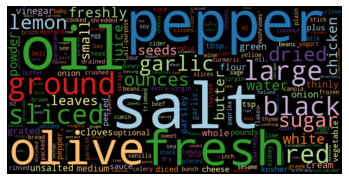

In [14]:
ingredient_count= count_words_ingredients(df)
print('Wordcloud for Ingredients')
wordcloud(ingredient_count['freq'])


Wordcloud for Recipe Titles


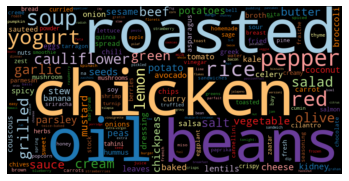

In [15]:
title_count=count_words_title(df)
print('Wordcloud for Recipe Titles')
wordcloud(title_count['freq'])

### Modeling

In [18]:

from sklearn.cluster import KMeans
kmeans_model=KMeans(n_clusters=10, random_state=509)
kmeans_model.fit(tfidf_ingredient_vectors)

KMeans(n_clusters=10, random_state=509)